In [81]:
import os
import numpy as np
import librosa
import joblib
import sounddevice as sd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
DATASET_PATH = "dataset_augmented"
SAMPLES_PER_FILE = 16000   # 1 sec @16kHz
N_MFCC = 13
MAX_LEN = 88

# -----------------------------
# Feature Extraction
# -----------------------------
def extract_features(file_path, n_mfcc=N_MFCC, max_len=MAX_LEN):
    audio, sr = librosa.load(file_path, sr=16000)
    audio, _ = librosa.effects.trim(audio, top_db=20)

    if len(audio) > SAMPLES_PER_FILE:
        audio = audio[:SAMPLES_PER_FILE]
    elif len(audio) < SAMPLES_PER_FILE:
        audio = np.pad(audio, (0, SAMPLES_PER_FILE - len(audio)), mode='constant')

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    if mfcc.shape[1] < max_len:
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc.flatten()

# -----------------------------
# Load Dataset
# -----------------------------
labels, features, paths = [], [], []

for label in os.listdir(DATASET_PATH):
    class_dir = os.path.join(DATASET_PATH, label)
    if not os.path.isdir(class_dir):
        continue
    for file in os.listdir(class_dir):
        if file.endswith(".wav"):
            file_path = os.path.join(class_dir, file)
            mfcc = extract_features(file_path)
            features.append(mfcc)
            labels.append(label)
            paths.append(file_path)   # Keep original paths

X = np.array(features)
y = np.array(labels)
X_paths = np.array(paths)

# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test, X_train_paths, X_test_paths = train_test_split(
    X, y_encoded, X_paths, test_size=0.2, random_state=42
)

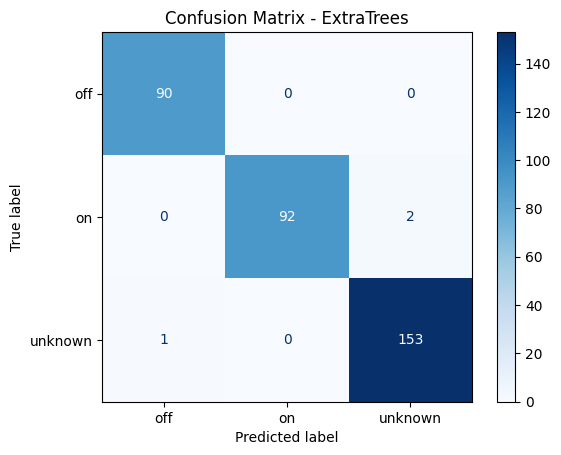

✅ Accuracy: 0.99
✅ Model and encoder saved.


In [82]:
label_to_int = dict(zip(encoder.classes_, range(len(encoder.classes_))))

class_weight = {
    label_to_int['on']: 2.0,
    label_to_int['off']: 1.0,
    label_to_int['unknown']: 1.0
}

# -----------------------------
# Pipeline & Model
# -----------------------------
mypipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", ExtraTreesClassifier(n_estimators=150,max_depth=15,class_weight=class_weight, random_state=42))
])

mypipeline.fit(X_train, y_train)

# -----------------------------
# Evaluate
# -----------------------------
y_pred = mypipeline.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - ExtraTrees")
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.2f}")

# -----------------------------
# Save model + encoder
# -----------------------------
joblib.dump(mypipeline, "on_off_rf_model.pkl")
joblib.dump(encoder, "label_encoder.pkl")
print("✅ Model and encoder saved.")

In [83]:
# -----------------------------
# Identify misclassified items
wrong_idx = np.where(y_test != y_pred)[0]
print(f"Number of misclassified items: {len(wrong_idx)}")

# -----------------------------
# Listen to misclassified items
for idx in wrong_idx:
    true_label = encoder.inverse_transform([y_test[idx]])[0]
    pred_label = encoder.inverse_transform([y_pred[idx]])[0]
    print(f"❌ True: {true_label} | Pred: {pred_label}")

    audio_path = X_test_paths[idx]
    y_audio, sr = librosa.load(audio_path, sr=16000)
    print("🎧 Playing audio...")
    sd.play(y_audio, sr)
    sd.wait()

    input("Press Enter to play next misclassified clip...")

Number of misclassified items: 3
❌ True: on | Pred: unknown
🎧 Playing audio...
❌ True: on | Pred: unknown
🎧 Playing audio...
❌ True: unknown | Pred: off
🎧 Playing audio...
